Equations for chemostat competition:  
$$
\frac{dX_A}{dt} = X_A ( \frac{\mu S}{S + k_A} - D ), \\
\frac{dX_C}{dt} = X_C ( \frac{\mu S}{S + k_C} * (1+s_C)  - D ), \\
\frac{dX_N}{dt} = X_N ( \frac{\mu S}{S + k_N} * (1+s_N) - D ), \\
\frac{dS}{dt} = ( S_0 - S ) D - \frac{X_A \mu S}{( S + k_A ) Y_A} - \frac{X_C \mu S * (1+s_C)}{( S + k_C ) Y_C} - \frac{X_N \mu S * (1+s_N)}{( S + k_N ) Y_N}.
$$

Where:
* $X_A$ is the density of the wildtype strain
* $X_C$ is the density of the CNV strain
* $X_N$ is the density of the SNV strain
* $S$ is the concentration of the limiting nutrient in the medium
* $S_0$ is the incoming substrate flow
* $Y_i$ is the culture yield of strain $i$ per mole of the limiting nutrient
* $D$ is the dilution rate of the culture
* $\mu$ is the maximal growth rate, related to the concentration of the limiting nutrient with saturating kinetics,
* $k_i$ is the substrate concentration at half-maximal $\mu$ for strain $i$ 
* $(1+s_C)$ is the increased growth in the chemostat conditions of the CNV strain
* $(1+s_N)$ is the increased growth in the chemostat conditions of the CNV strain


Equations for mutation from ancestral genotype to mutant genotype:

$$
\frac{dX_A}{dt} = (1 - \delta_C - \delta_S) X_A,\\
\frac{dX_C}{dt} = \delta_C X_A, \\
\frac{dX_N}{dt} = \delta_N X_A.
$$


Based on Airoldi et al. 2016 https://doi.org/10.1091/mbc.E14-05-1013, the values for the parameters are:

* $k_i$ = 103µM nitrogen = 0.103 mM
* $Y$ = 32,445 ± 3422 cells/ml per μmol of nitrogen = 32,445,000 cells/ml/mmol nitrogen
* at steady state, $S$ = ∼80 μM = ~0.08 mM

Based on Cooper TG (1982):
* $\mu_A$ = 0.45 h-1

From experiments:
* $D$ = 0.12 h-1
* $S_0$ = 800 μM = 0.8 mM
* at steady state, cell density ~1.5e7 cells/ml

This results in a doubling time of 5.8 hours, which is equal to 0.1724 generations h-1

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numba

In [2]:
@numba.jit
def get_rates(A, CNV, SNV, S, k, D, μA, m_cnv, m_snv, s_cnv, s_snv):
    """ Rates
    A :  number of ancestral cells at current time step
    CNV : number of cells with CNV at current time step
    SNV : number of cells with SNV at current time step
    S : substrate concentration at current time step
    k : substrate concentration at half-maximal growth rate (here, the same for all cells)
    D : dilution rate
    μA : ancestral maximum growth rate
    m_cnv : ancestral -> CNV mutation rate
    m_snv : ancestral -> SNV mutation rate
    s_cnv : CNV selection coefficient
    s_snv : SNV selection coefficient
    """
    return np.array([
        A* ((μA *S) / (k + S)), # growth ancestral
        A*D, # dilution ancestral
        CNV * (((μA+s_cnv) *S) / (k + S)), # growth CNV 
        CNV*D, # dilution CNV
        SNV * (((μA+s_snv) *S) / (k + S))*(1+s_snv), # growth SNV
        SNV*D, # dilution SNV
        A * m_cnv, # ancestral -> CNV
        A * m_snv]#, # ancestral -> SNV
        #(S0-S)*D] # substrate dilution
    )

# updates = np.array([
#     [1, 0, 0, -1/y], # growth ancestral
#     [-1, 0, 0, 0], # dilution ancestral
#     [0, 1, 0, -1/y],  # growth CNV
#     [0, -1, 0, 0], # dilution CNV
#     [0, 0, 1, -1/y],  # growth SNV
#     [0, 0, -1, 0], # dilution SNV
#     [-1, 1, 0, 0], # mutation ancestral -> CNV
#     [-1, 0, 1, 0], # mutation ancestral -> SNV
#     [0, 0, 0, -1] # dilution substrate
# ])
updates = np.array([
        [1, 0, 0], # growth ancestral
        [-1, 0, 0], # dilution ancestral
        [0, 1, 0],  # growth CNV
        [0, -1, 0], # dilution CNV
        [0, 0, 1],  # growth SNV
        [0, 0, -1], # dilution SNV
        [-1, 1, 0], # mutation ancestral -> CNV
        [-1, 0, 1] # mutation ancestral -> SNV
    ])

@numba.jit
def draw_time(rates):
    """Time for next reaction
    Takes the output (as array) of get_rates()
    """
    total_rate = rates.sum()
    return np.random.exponential(1/total_rate)

def draw_reaction(rates):
    """Get reaction type
    Takes the output (as array) of get_rates()
    """
    rates /= rates.sum()
    return np.random.multinomial(1, rates).argmax()

def gillespie_step(A, CNV, SNV, S, k, D, μA, m_cnv, m_snv, s_cnv, s_snv, updates, S0, y):
    """ Single update of simulation
    A :  number of ancestral cells at current time step
    CNV : number of cells with CNV at current time step
    SNV : number of cells with SNV at current time step
    S : substrate concentration at current time step
    k : substrate concentration at half-maximal growth rate (here, the same for all cell types)
    D : dilution rate
    μA : ancestral maximum growth rate
    m_cnv : ancestral -> CNV mutation rate
    m_snv : ancestral -> SNV mutation rate
    s_cnv : CNV selection coefficient
    s_snv : SNV selection coefficient
    updates : change in reactants due to reactions
    S0 : incoming substrate concentration, - S0 in diff eq
    y : number of cells produced per mole of the limiting nutrient (here, the same for all cell types)
    """
    rates = get_rates(A, CNV, SNV, S, k, D, μA, m_cnv, m_snv, s_cnv, s_snv)
    Δt = draw_time(rates)
    ri = draw_reaction(rates)
    ΔA, ΔCNV, ΔSNV = updates[ri]
    ΔS = I*D - D*S - (A*μA*S)/((S+k)*y) - (CNV*(μA*(1+s_cnv))*S)/((S+k)*y) - (SNV*(μA*(1+s_snv))*S)/((S+k)*y)
    return Δt, ΔA, ΔCNV, ΔSNV, ΔS

def τ_leap(A, CNV, SNV, S, k, D, μA, m_cnv, m_snv, s_cnv, s_snv, S0, y, τ):
    """ Single update of simulation using tau leaps
    A :  number of ancestral cells at current time step
    CNV : number of cells with CNV at current time step
    SNV : number of cells with SNV at current time step
    S : substrate concentration at current time step
    k : substrate concentration at half-maximal growth rate (here, the same for all cell types)
    D : dilution rate
    μA : ancestral maximum growth rate
    m_cnv : ancestral -> CNV mutation rate
    m_snv : ancestral -> SNV mutation rate
    s_cnv : CNV selection coefficient
    s_snv : SNV selection coefficient
    updates : change in reactants due to reactions
    S0 : incoming substrate concentration - S0 in diff eq
    y : number of cells produced per mole of the limiting nutrient (here, the same for all cell types)
    τ : amount to advance time
    """
    rates = get_rates(A, CNV, SNV, S, k, D, μA, m_cnv, m_snv, s_cnv, s_snv)
    try:
        adj_rates = np.random.poisson(rates * τ)
    except ValueError:
        print(rates, τ)
        raise
    if (adj_rates > 150).any() and τ > 1/100:
        τ /= 2
    ΔA, ΔCNV, ΔSNV = updates.T @ adj_rates
    A += ΔA
    CNV += ΔCNV
    SNV += ΔSNV
    ΔS = S0*D - D*S - (A*μA*S)/((S+k)*y) - (CNV*(μA+s_cnv)*S)/((S+k)*y) - (SNV*(μA+s_snv)*S)/((S+k)*y)
    return τ, A, CNV, SNV, S+ΔS

In [3]:
def CNVsimulator_simpleChemo(A_inoculation, S_init, k, D, μA, m_snv, s_snv, S0, y, τ, seed=None, **kwargs):
    """ Simulates CNV and SNV evolution in a steady state chemostat for 267 generations, which is 1548.6 hours
    Begins counting generations after 48 hours, during which time the chemostat reaches steady state
    Returns proportion of the population with a CNV for generations observed in Lauer et al. 2018 as 1d np.array of length 25
    
    A_inoculation :  cell density at inoculation with ancestral type
    S_init : initial substrate concentration in chemostat
    k : substrate concentration at half-maximal growth rate (here, the same for all cell types)
    D : dilution rate
    μA : ancestral maximum growth rate
    m_snv : ancestral -> SNV mutation rate
    s_snv : SNV selection coefficient
    updates : change in reactants due to reactions
    S0 : incoming substrate concentration - S0 in diff eq
    y : number of cells produced per mole of the limiting nutrient (here, the same for all cell types)
    τ : amount to advance time
    m_cnv : ancestral -> CNV mutation rate
    s_cnv : CNV selection coefficient
    seed : int
    
    Depending on what the downstream inference is, the following parameters are can be passed
    cnv_params : np.array, 1d of length dim_param
        Parameter vector with the log 10 selection coefficient and log 10 cnv mutation rate, for use with SNPE or to build observed data
    parameters : instance of parameters
        has attribute s, float, log 10 selection coefficient
        has attribute m, float, log 10 cnv mutation rate
        for use with pyABC
    """
    cnv_params = kwargs.get('cnv_params', None)
    parameters = kwargs.get('parameters', None)
    
    if seed is not None:
        np.random.seed(seed=seed)
    else:
        np.random.seed()

    
    assert A_inoculation > 0
    A_inoculation = np.uint64(A_inoculation)
    
    if isinstance(cnv_params, np.ndarray):
        s_cnv, m_cnv = np.power(10,cnv_params)
    else:
        s_cnv = np.power(10,parameters.s)
        m_cnv = np.power(10,parameters.m)
        
    s_cnv /= 5.8 #convert from per generation to per hour
    m_cnv /= 5.8 #convert from per generation to per hour
    s_snv /= 5.8
    m_snv /= 5.8


    A = A_inoculation
    S = S_init # initial substrate concentration = concentration in media
    CNV, SNV = 0, 0
    t=0
    
    while t < 48: # allow chemostat to reach steady state
        τ, A, CNV, SNV, S = τ_leap(A, CNV, SNV, S, k, D, μA, m_cnv, m_snv, s_cnv, s_snv, S0, y, τ)
        A = max(A, 0)
        CNV = max(CNV, 0)
        SNV = max(SNV, 0)
        S = max(S, 0)
        t += τ
        
    t=0
    states = [np.array([A, CNV, SNV, S])]
    times=[t]
    while t < 1548.6: # record from when the chemostat reaches steady state to gen 267
        τ, A, CNV, SNV, S = τ_leap(A, CNV, SNV, S, k, D, μA, m_cnv, m_snv, s_cnv, s_snv, S0, y, τ)
        A = max(A, 0)
        CNV = max(CNV, 0)
        SNV = max(SNV, 0)
        S = max(S, 0)
        t+=τ
        states.append(np.array([A, CNV, SNV, S]))
        times.append(t)
    
    data = np.stack(states, axis=1)
    times=np.array(times)
    gens=times/5.8 #convert hours to generations
    #these were the generations observed in Lauer et al. 2018, so the time points at which we will record the state
    exp_gen = np.array([25,33,41,54,62,70,79,87,95,103,116,124,132,145,153,161,174,182,190,211,219,232,244,257,267])
    #get the indices closest to the generations observed
    ngens = len(exp_gen)
    indices = np.empty(ngens, dtype=int)
    for i in range(ngens):
        ab = np.abs(gens-exp_gen[i])
        indices[i] = ab.argmin()
    # convert pop densities for each of three states to cnv proportion
    p_cnv = data[1,:] / data[0:3,:].sum(axis=0)
    
    return np.transpose(p_cnv)[indices]

In [62]:
A_inoc = 1e5
S_init = .800
s_snv=0.001
m_snv=1e-5 
cnv_params=np.array([np.log10(0.05), np.log10(1e-3)])
D=0.12
μA=0.45
k=.103
#y=3244500
y=324450000
S0=.800
τ=1/10
exp_gen = np.array([25,33,41,54,62,70,79,87,95,103,116,124,132,145,153,161,174,182,190,211,219,232,244,257,267])

In [63]:
#this is the version that will return data the way it is needed for  inference
cnv_data = CNVsimulator_simpleChemo(A_inoc, S_init, k, D, μA, m_snv, s_snv, S0, y, τ, seed=1, cnv_params=cnv_params)
cnv_data

array([0.0412034 , 0.05361711, 0.06717508, 0.09167694, 0.10844706,
       0.12647913, 0.14836269, 0.16932061, 0.19162752, 0.2151706 ,
       0.25611345, 0.28282705, 0.31056643, 0.35749976, 0.38713205,
       0.41725206, 0.46683104, 0.49735267, 0.52750364, 0.60411589,
       0.63191403, 0.67520878, 0.71246324, 0.74953897, 0.77573116])

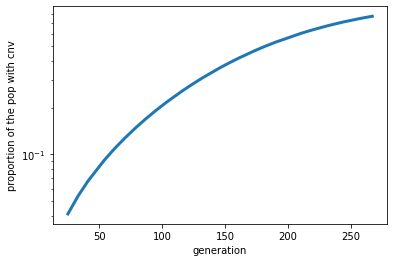

In [64]:
fig, ax = plt.subplots()
ax.plot(exp_gen, cnv_data, lw=3)
ax.set_xlabel('generation')
ax.set_ylabel('proportion of the pop with cnv')
ax.set_yscale('log');

In [65]:
#this version will allow us to plot the different classes and the substrate conc
s_cnv, m_cnv = np.power(10, cnv_params)
s_cnv /= 5.8 #convert from per generation to per hour
m_cnv /= 5.8 #convert from per generation to per hour
s_snv /= 5.8
m_snv /= 5.8

A = A_inoc
S = S_init # initial substrate concentration = concentration in media
CNV, SNV = 0, 0
t = 0

states = [np.array([A, CNV, SNV, S])]
times=[t]
while t < 1548.6: # record from when the chemostat reaches steady state to gen 267
    τ, A, CNV, SNV, S = τ_leap(A, CNV, SNV, S, k, D, μA, m_cnv, m_snv, s_cnv, s_snv, S0, y, τ)
    A = max(A, 0)
    CNV = max(CNV, 0)
    SNV = max(SNV, 0)
    S = max(S, 0)
    t+=τ
    states.append(np.array([A, CNV, SNV, S]))
    times.append(t)
    
data = np.stack(states, axis=1)
times = np.array(times)
gens = times/5.8

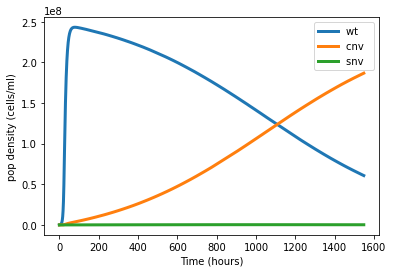

In [66]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(times, data[0,:], lw=3, label='wt ' + " ")
ax.plot(times, data[1,:], lw=3, label='cnv ' + " ")
ax.plot(times, data[2,:], lw=3, label='snv ' + " ")
ax.set_xlabel('Time (hours)')
ax.set_ylabel('pop density (cells/ml)')
ax.legend()

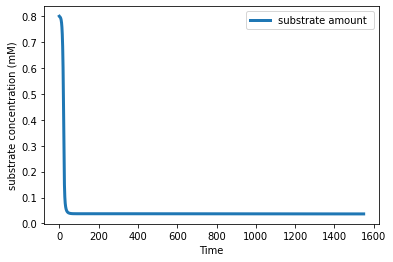

In [67]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(times, data[3,:], lw=3, label='substrate amount' + " ")
ax.set_xlabel('Time')
ax.set_ylabel('substrate concentration (mM)')
ax.legend()